<a href="https://colab.research.google.com/github/Thom-ar/Dio_MLAprendizado/blob/main/Aprendizado_por_transferencia_DIO_Thomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por transferência / Ajuste fino
Este tutorial irá guiá-lo pelo processo de usar aprendizado por transferência para criar um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treinamento. De maneira geral, o aprendizado por transferência refere-se ao processo de aproveitar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente, que foi treinada anteriormente com bom desempenho em um conjunto de dados maior, e usá-la como base para um novo modelo que aproveita a precisão dessa rede anterior para uma nova tarefa. Esse método se tornou popular nos últimos anos para melhorar o desempenho de uma rede neural treinada com um conjunto de dados pequeno; a ideia é que o novo conjunto de dados pode ser muito pequeno para ser treinado com bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender características de imagens muitas vezes aprende características semelhantes, especialmente nas camadas iniciais, onde são mais genéricas (detectores de bordas, blobs, e assim por diante).

O aprendizado por transferência foi amplamente viabilizado pela liberação de código aberto de modelos de última geração; para os modelos de melhor desempenho em tarefas de classificação de imagens (como os do ILSVRC), é prática comum não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagens de ponta para melhorar o desempenho de seus próprios modelos específicos de tarefa.

**Extração de características vs. ajuste fino**  
Em um extremo, o aprendizado por transferência pode envolver pegar a rede pré-treinada e congelar os pesos, usando uma de suas camadas ocultas (geralmente a última) como extrator de características, utilizando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para esse procedimento é "ajuste fino" porque estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa. Normalmente, treinamos essa rede com uma taxa de aprendizado mais baixa, pois esperamos que as características já sejam relativamente boas e não precisem ser alteradas muito.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas, mas ajustamos as camadas posteriores. A melhor estratégia depende do tamanho do seu conjunto de dados, do número de classes e de quão semelhante ele é ao conjunto de dados no qual o modelo anterior foi treinado (e, assim, se pode se beneficiar dos mesmos extratores de características aprendidos). Uma discussão mais detalhada sobre como estrategizar pode ser encontrada em [1] [2].

**Procedimento**  
Neste guia, vamos passar pelo processo de carregar um classificador de imagens de última geração, o VGG16, que venceu o desafio do ImageNet em 2014, e usá-lo como um extrator de características fixo para treinar um classificador customizado menor com nossas próprias imagens. Embora com muito poucas mudanças no código, você também pode tentar o ajuste fino.

Primeiro, carregaremos o VGG16 e removeremos sua camada final, a camada de classificação softmax de 1000 classes específica para o ImageNet, substituindo-a por uma nova camada de classificação para as classes sobre as quais estamos treinando. Em seguida, vamos congelar todos os pesos da rede, exceto os novos que conectam à nova camada de classificação, e treinar a nova camada de classificação sobre o nosso novo conjunto de dados.

Também vamos comparar esse método com o treinamento de uma rede neural pequena do zero no novo conjunto de dados e, como veremos, isso irá melhorar dramaticamente nossa precisão. Faremos essa parte primeiro.

Como nosso sujeito de teste, usaremos um conjunto de dados composto por cerca de 6000 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão sobre ele. Vale ressaltar que essa estratégia escala bem para conjuntos de imagens nos quais você pode ter até apenas algumas centenas de imagens ou menos. Seu desempenho será menor com um número reduzido de amostras (dependendo das classes), como de costume, mas ainda impressionante considerando as limitações habituais.

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# Obtendo um conjunto de dados
O primeiro passo será carregar nossos dados. Como exemplo, usaremos o conjunto de dados CalTech-101, que contém cerca de 9000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, vamos excluir 5 das categorias que possuem mais imagens. Isso é para manter a distribuição das classes relativamente equilibrada (cerca de 50-100 imagens por classe) e restrita a um número menor de imagens, cerca de 6000.

Para obter este conjunto de dados, você pode executar o script de download **download.sh** na pasta de dados, ou os seguintes comandos:



```
wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
tar -xvzf 101_ObjectCategories.tar.gz
```
Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma que o **101_ObjectCategories**, com todas as imagens organizadas em subpastas, uma para cada classe. Neste caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente, bastando substituir "root" pela sua pasta. Se você tiver uma estrutura alternativa, basta garantir que carregue a lista de dados onde cada elemento seja um dicionário, onde **x** é os dados (um array 1D do numpy) e **y** é o rótulo (um número inteiro). Use a função auxiliar **get_image(path)** para carregar a imagem corretamente no array e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para o VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-las no seu disco rígido, pois isso já está sendo feito no código abaixo.

Se você tiver o **101_ObjectCategories** na sua pasta de dados, a célula a seguir deve carregar todos os dados.


In [2]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


############################################################################################# 100.0%

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
drive  sample_data


In [3]:
root = '/content/drive/Othercomputers/Meu computador/Google drive/Amostras'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/drive/Othercomputers/Meu computador/Google drive/Amostras/Frutas', '/content/drive/Othercomputers/Meu computador/Google drive/Amostras/Passaros']


Essa função é útil para pré-processar os dados em uma imagem e vetor de entrada.

In [4]:
# Função auxiliar para carregar a imagem e retornar a imagem e o vetor de entrada.
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando as imagens da pasta do drive

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [6]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(30, 2)


Let's get a summary of what we have.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 200 images from 2 categories
train / validation / test split: 140, 30, 30
training data shape:  (140, 224, 224, 3)
training labels shape:  (140, 2)


Se tudo funcionou corretamente, você deveria ter carregado um conjunto de imagens e as dividido em três conjuntos: train, val e test. A forma dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso de 101_ObjectCategories).

Observe que dividimos todos os dados em três subconjuntos - um conjunto de treinamento train, um conjunto de validação val e um conjunto de teste test. A razão para isso é avaliar corretamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem excesso de ajuste ao conjunto de treinamento. O conjunto de test é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de amostra do nosso conjunto de dados.


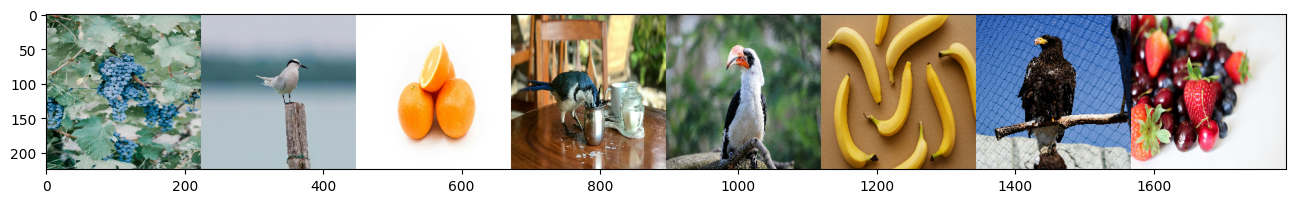

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Primeiro treinamento de uma rede neural do zero

Antes de realizar a transferência de aprendizado, vamos primeiro construir uma rede neural do zero para classificar nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede treinada por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de max-pooling alternadas, seguidas por um dropout após cada par conv/pooling. Após a última camada de pooling, vamos adicionar uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será AdaDelta. Várias coisas sobre esta rede podem ser alteradas para obter um melhor desempenho, talvez usando uma rede maior ou um otimizador diferente ajudará, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, e assim não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas."

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de tamanho médio com cerca de 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles leva à única camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo por 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos traçar a perda ao longo do tempo mais tarde.

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4978 - loss: 0.7119 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5563 - loss: 0.6741 - val_accuracy: 0.4333 - val_loss: 0.7094
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6248 - loss: 0.6512 - val_accuracy: 0.7333 - val_loss: 0.6680
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6642 - loss: 0.6162 - val_accuracy: 0.7000 - val_loss: 0.6555
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7179 - loss: 0.5860 - val_accuracy: 0.6000 - val_loss: 0.6823
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6863 - loss: 0.5713 - val_accuracy: 0.6333 - val_loss: 0.6313
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7478 - loss: 0.5014 - val_accuracy: 0.7000 - val_loss: 0.6122
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7721 - loss: 0.4920 - val_accuracy: 0.5667 - val_loss: 0.7712
Epoch 9/1

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

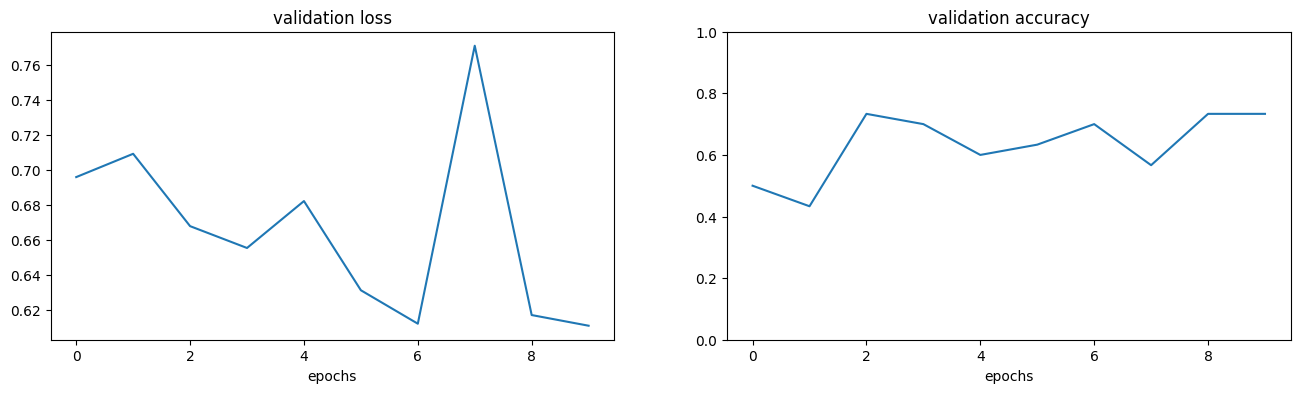

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a realmente aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a sobreajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado mais cedo por volta dessa época. No entanto, nossa precisão provavelmente não teria sido acima de 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4987024962902069
Test accuracy: 0.7666666507720947


Finalmente, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6000 imagens, considerando que se tivéssemos usado uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.
# Transferir aprendizado começando com a rede existente
Agora podemos prosseguir para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Depois que a rede for carregada, podemos inspecionar novamente as camadas com o método summary().

In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma taxa de erro top-5 de 8,8%, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão top-1 — equivalente à métrica de precisão que temos usado (que a previsão superior está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a segunda para a última camada, e então trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe keras Model para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está na verdade apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente esta rede, model_new no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda devem ser bastante relevantes para a nova tarefa de classificação de imagem. Não é ótimo, mas provavelmente melhor do que o que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador trainable como falso em cada camada (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos, e simplesmente treinamos os pesos na única camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se parecer muito com o ImageNet, pode ser vantajoso ajustar finamente algumas das camadas VGG junto com o novo classificador, ou possivelmente até todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de recursos, temendo que o ajuste fino demais com este conjunto de dados possa causar overfitting. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então, vamos congelar as camadas e compilar o novo modelo com exatamente o mesmo otimizador e função de perda do nosso primeiro modelo, para uma comparação justa. Em seguida, executamos summary novamente para ver a arquitetura da rede.

In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto pela última camada, anteriormente uma softmax de 1000 neurônios, que foi substituída por uma nova softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que eles estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que é na verdade apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, prosseguimos e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) como antes, juntamente com o mesmo algoritmo de otimização. Também acompanhamos seu histórico conforme avançamos.

In [20]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 113s 28s/step - accuracy: 0.4411 - loss: 0.7999 - val_accuracy: 0.4000 - val_loss: 0.7849
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 28s/step - accuracy: 0.5342 - loss: 0.7079 - val_accuracy: 0.6000 - val_loss: 0.9278
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 108s 28s/step - accuracy: 0.4775 - loss: 1.1456 - val_accuracy: 0.7000 - val_loss: 0.5149
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 144s 27s/step - accuracy: 0.6126 - loss: 0.5717 - val_accuracy: 0.5667 - val_loss: 0.6803
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 137s 25s/step - accuracy: 0.5853 - loss: 0.6142 - val_accuracy: 0.7000 - val_loss: 0.5769
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 144s 27s/step - accuracy: 0.6859 - loss: 0.5304 - val_accuracy: 0.8667 - val_loss: 0.3846
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 141s 26s/step - accuracy: 0.8969 - loss: 0.3979 - val_accuracy: 0.8000 - val_loss: 0.3850
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 147s 27s/step - accuracy: 0.7548 - loss: 0.4325 - val_accuracy: 0.8667 - val_loss:

Nossa precisão de validação fica próxima de 80% no final, o que representa uma melhoria de mais de 30% em relação à rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale ressaltar também que esta rede treina ligeiramente mais rápido que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque o congelamento dos pesos elimina a necessidade de retropropagar por todas essas camadas, economizando tempo de execução.

Vamos plotar novamente a perda e a precisão de validação, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo treinado por transferência em verde.

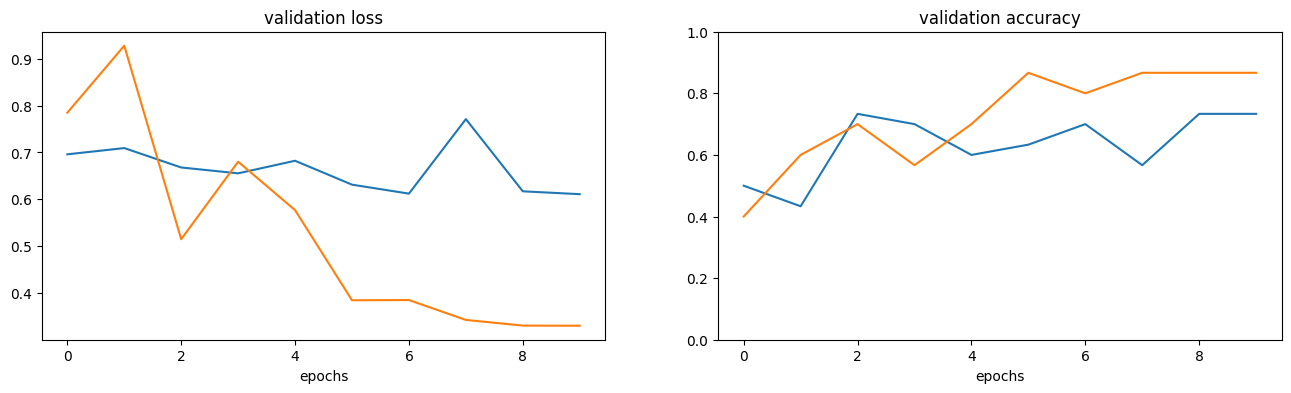

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a sobreajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente por 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais abandono, mas certamente não teríamos compensado a melhoria de >30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [23]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3301559388637543
Test accuracy: 0.8666666746139526


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [25]:
img, x = get_image('/content/drive/Othercomputers/Meu computador/Google drive/Amostras/Passaros/Birds(1).jpg')
probabilities = model_new.predict([x])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Melhorando os resultados

78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que alcançou 73% de precisão top-1 em 1000 classes. No entanto, é muito melhor do que o que conseguimos alcançar com nossa rede original, e há espaço para melhoria. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

Usando aumento de dados: aumento refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância a tais distorções.

Usando um otimizador diferente, adicionando mais regularização/dropout e outros hiperparâmetros.

Treinando por mais tempo (é claro)

Um exemplo mais avançado de aprendizado de transferência em Keras, envolvendo aumento para um pequeno conjunto de dados de 2 classes, pode ser encontrado no blog Keras.